# Plan projektu:

- wizualizacja danych
- czy grayscaling pomaga i wniosek że w sumie nie psuje
- KNN
- PCA/KPCA a następnie KNN
- Gradient boosting
- SVM

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import scipy.stats as sstats
from sklearn.model_selection import train_test_split
from sklearn.cluster import Birch
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn import (datasets, decomposition, ensemble, manifold, random_projection)
import tqdm

from KNN import KNN

## Data visualization
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class.

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

data_batch_1 = unpickle('cifar10/data_batch_1')
db1_labels = np.array(data_batch_1[b'labels'])
db1_data = np.array(data_batch_1[b'data'])

In [3]:
def make_viewables(db_data_photos):
    res = []
    for i in range(db_data_photos.shape[0]):
        res.append(db_data_photos[i].reshape(3,1024).T.reshape(32,32,3))
    return np.array(res)

db1_df = make_viewables(db1_data)

In [25]:
photo_indexes_to_show = np.random.randint(0, len(db1_data), size=100)
# photo_indexes_to_show

<Figure size 432x288 with 0 Axes>

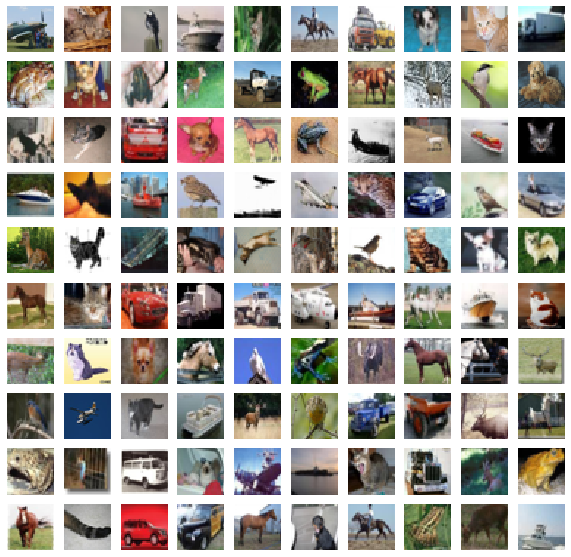

<Figure size 432x288 with 0 Axes>

In [32]:
f, axes = plt.subplots(10, 10, figsize=(10,10))
for i in range(10):
    for j in range(10):
        axes[i][j].imshow(db1_df[photo_indexes_to_show[10*i+j]])
        axes[i][j].axis('off')
plt.axis('off')
plt.figure()

## Does grayscaling affects image classification on this exact dataset?

Since it's speeding up computations.

In [33]:
def to_grayscale(x):
    new_x = x[:,:,0] * 0.3 + x[:, :, 1] * 0.59 + x[:, :, 2] * 0.11
    return new_x.astype(int)

In [35]:
train_x, test_x, train_y, test_y = train_test_split(db1_data, db1_labels, test_size=0.33)
train_x = train_x.reshape(-1, 32*32, 3)
test_x = test_x.reshape(-1, 32*32, 3)
gray_train_x = to_grayscale(train_x)
gray_test_x = to_grayscale(test_x)

ks = np.arange(10, 30, 2)
knn = KNN(train_x.reshape(-1, db1_data.shape[1]), train_y, test_x.reshape(-1, db1_data.shape[1]), ks)

original = []
grayscaled = []
for k in ks:
    original.append(np.count_nonzero(knn[k] == test_y) / len(test_y))

knn = KNN(gray_train_x, train_y, gray_test_x, ks)
for k in ks:
    grayscaled.append(np.count_nonzero(knn[k] == test_y) / len(test_y))

<Figure size 432x288 with 0 Axes>

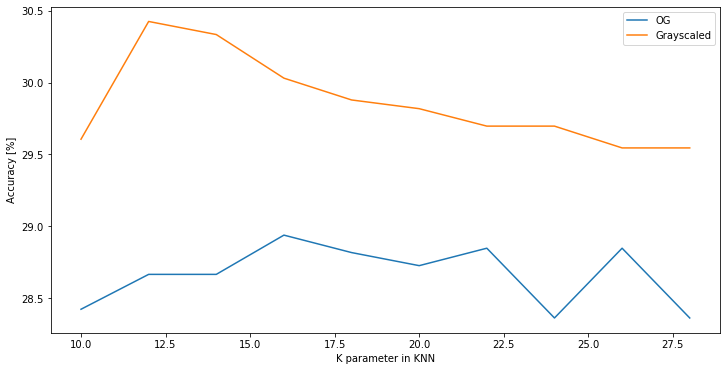

<Figure size 432x288 with 0 Axes>

In [56]:
plt.subplots(figsize=(12,6))
plt.plot(ks, np.array(original)*100, label='OG')
plt.plot(ks, np.array(grayscaled)*100, label='Grayscaled')
plt.ylabel('Accuracy [%]')
plt.xlabel('K parameter in KNN')
plt.legend()
plt.figure()

## CIFAR-10 classification using k-nearest-neighbours algorithm

#### Comparison of parameters such as:
- number of neighbours to consider

#### Dimension reduction methods:
- sparse random projection
- PCA
- KPCA

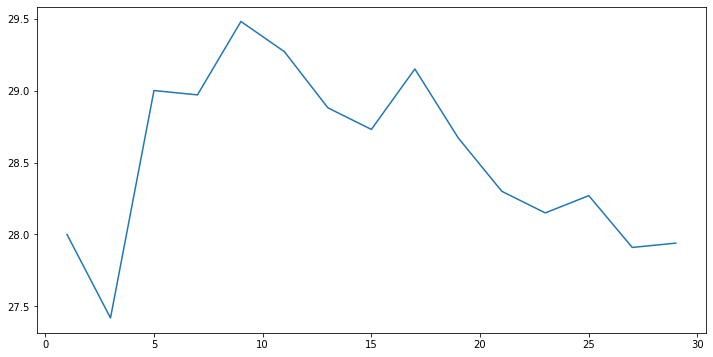

In [99]:
train_x, test_x, train_y, test_y = train_test_split(db1_data, db1_labels, test_size=0.33)
K = np.arange(1,30,2)
knn = KNN(train_x, train_y, test_x, K)
accs = []
for k in K:
    accs.append(np.round(np.count_nonzero(knn[k] == test_y)/len(test_y) * 100, 2))

plt.subplots(figsize=(12,6))
plt.plot(K, accs)

In [100]:
print("Best K param: ",K[np.argmax(accs)])
print("Accuracy with this k:", np.max(accs))

Best K param:  9
Accuracy with this k: 29.48


### Sparse random projection
opis

In [87]:
def sum_up(preds, t):
    print(f"Accuracy: {np.count_nonzero(preds == t)/len(t)} %")
    print(confusion_matrix(t, preds))
    
def sparseRandomProj():
    OS = np.arange(10,150,5)
    acc = []
    for oss in tqdm.tqdm(OS):
        srp = random_projection.SparseRandomProjection(n_components=oss)
        x_proj = srp.fit_transform(train_x)
        x_test_proj = srp.transform(test_x)
        knn = KNN(x_proj, train_y, x_test_proj, [7])

        temp_acc = np.round(np.count_nonzero(knn[7] == test_y)/len(test_y),2)*100
        acc.append(temp_acc)
#         print(f"KNN accuracy: {temp_acc} % on {oss} axes")
    return acc, OS

spr = sparseRandomProj()

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [01:02<00:00,  2.22s/it]


<Figure size 432x288 with 0 Axes>

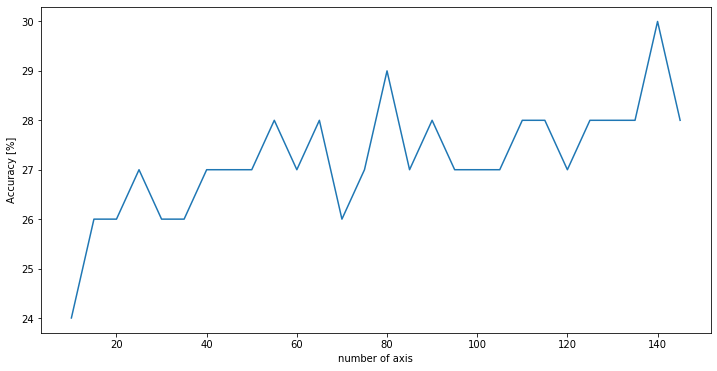

<Figure size 432x288 with 0 Axes>

In [91]:
plt.subplots(figsize=(12,6))
plt.plot(spr[1], spr[0])
plt.ylabel('Accuracy [%]')
plt.xlabel('number of axis')
plt.figure()

### Principial Component Analysis
opis

In [102]:
def pca():
#     print("PCA")
    OS = np.arange(10,100,5)

    accs = []
    for oss in OS:
        pca = decomposition.PCA(n_components=oss)
        x_proj = pca.fit_transform(train_x)
        x_test_proj = pca.transform(test_x)
        knn = KNN(x_proj, train_y, x_test_proj, [7])

    #     sum_up(knn[7], testy)
        temp_acc = np.round(np.count_nonzero(knn[7] == test_y)/len(test_y),2)*100
        accs.append(temp_acc)
#         print(f"KNN accuracy: {temp_acc} % on {oss} axes")

#     accuracy_plot(OS, accs)
    return accs, OS
    
pca_accs = pca()

<Figure size 432x288 with 0 Axes>

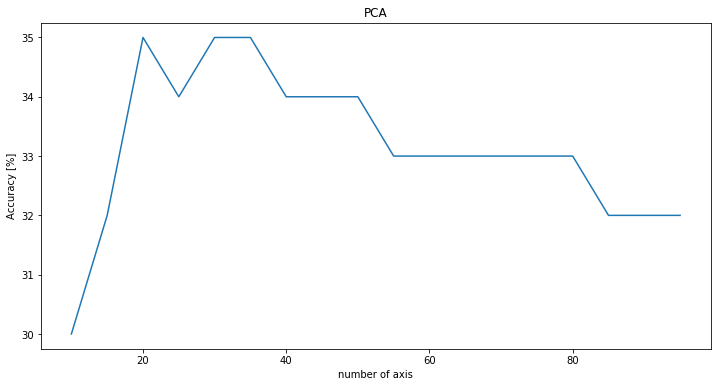

<Figure size 432x288 with 0 Axes>

In [104]:
plt.subplots(figsize=(12,6))
plt.plot(pca_accs[1], pca_accs[0])
plt.title("PCA")
plt.ylabel('Accuracy [%]')
plt.xlabel('number of axis')
plt.figure()

## Kernelised PCA
Comparison of linear, polynomial, rbf, sigmoid and cosine kernels.

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:54<00:00, 94.90s/it]


<Figure size 432x288 with 0 Axes>

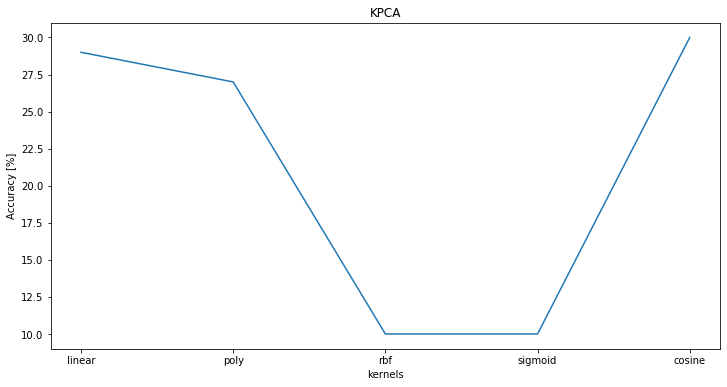

<Figure size 432x288 with 0 Axes>

In [106]:
def kpca_kernels_comparison():
    kers = ['linear','poly','rbf', 'sigmoid', 'cosine']

    accs = []
    for ker in tqdm.tqdm(kers):
        kpca = decomposition.KernelPCA(n_components=None, kernel=ker, gamma=0.01)
        x_proj = kpca.fit_transform(train_x)
        x_test_proj = kpca.transform(test_x)
        knn = KNN(x_proj, train_y, x_test_proj, [7])

        temp_acc = np.round(np.count_nonzero(knn[7] == test_y)/len(test_y),2)*100
        accs.append(temp_acc)
    return accs, kers
    
kpca_kernels = kpca_kernels_comparison()
plt.subplots(figsize=(12,6))
plt.plot(kpca_kernels[1], kpca_kernels[0])
plt.title("KPCA")
plt.ylabel('Accuracy [%]')
plt.xlabel('kernels')
plt.figure()

#### KPCA linear kernel

In [ ]:
def KPCA_linear():
    comps = np.arange(10,30,2)
    accs = []
    for i in tqdm.tqdm(comps):
        kpca = decomposition.KernelPCA(n_components=i, kernel='linear')
        x_proj = kpca.fit_transform(train_x)
        x_test_proj = kpca.transform(test_x)
        knn = KNN(x_proj, train_y, x_test_proj, [7])

        temp_acc = np.round(np.count_nonzero(knn[7] == test_y)/len(test_y),2)*100
        accs.append(temp_acc)
    
    return accs, comps
        
kpca_lin = KPCA_linear()

In [ ]:
plt.subplots(figsize=(12,6))
plt.plot(kpca_lin[1], kpca_lin[0])
plt.title("KPCA with linear kernel")
plt.ylabel('Accuracy [%]')
plt.xlabel('Number of components')
plt.figure()